In [10]:
import pandas as pd
import numpy as np
import joblib
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("dataset.csv")
df

,headline,label,Unnamed: 2,Unnamed: 3
0,cock suck before you piss around on my work,1,NaN,NaN
1,you are gay or antisemmitian archangel white ...,1,NaN,NaN
2,fuck your filthy mother in the ass dry,1,NaN,NaN
3,get fuck ed up get fuck ed up got a drink t...,1,NaN,NaN
4,stupid peace of shit stop deleting my stuff ...,1,NaN,NaN
...,...,...,...,...
72415,"Black ppl aren't expected to do anything, depe...",1,NaN,NaN
72416,Turner did not withhold his disappointment. Tu...,1,NaN,NaN
72417,I swear to God. This dumb nigger bitch. I have...,1,NaN,NaN
72418,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,1,NaN,NaN


In [4]:
df_cleaned = df[df['label'].isin(['0', '1'])].copy()
# Drop the unused columns
df_cleaned = df_cleaned.drop(columns=['Unnamed: 2', 'Unnamed: 3'])
# Convert label to int
df_cleaned['label'] = df_cleaned['label'].astype(int)
# Strip whitespace from headline
df_cleaned['headline'] = df_cleaned['headline'].str.strip()
# Drop duplicates
df_cleaned = df_cleaned.drop_duplicates()
# remove @ user
df_cleaned['headline'] = df_cleaned['headline'].str.replace(r'@[\w]*', '', regex=True)
# remove extra letters
df_cleaned['headline'] = df_cleaned['headline'].str.replace("[^a-zA-Z#]", "")
# remove links
df_cleaned['headline'] = df_cleaned['headline'].str.replace(r'http\S+|www.\S+', '', regex=True)
df_cleaned

,headline,label
0,cock suck before you piss around on my work,1
1,you are gay or antisemmitian archangel white ...,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1
...,...,...
72415,"Black ppl aren't expected to do anything, depe...",1
72416,Turner did not withhold his disappointment. Tu...,1
72417,I swear to God. This dumb nigger bitch. I have...,1
72418,Yea fuck you RT : IF YOURE A NIGGER FUCKING UN...,1


In [6]:
def performdata(df_cleaned):
    total = df_cleaned.shape[0]
    non_bully = df_cleaned[df_cleaned['label']==0].shape[0]
    slices = [non_bully/total, (total-non_bully)/total]
    labeling = ['Non-Bullying', 'Bullying']
    explode = [0.2, 0]
    
    plt.pie(slices, explode = explode, shadow=True, autopct="%1.2f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})
    plt.title('Number of Bullying Vs Non - Bullying')
    plt.tight_layout()
    plt.show()

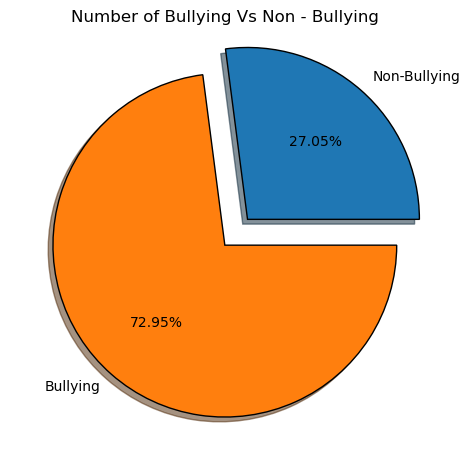

In [12]:
performdata(df_cleaned)

In [14]:
X = df_cleaned['headline']
y = df_cleaned['label'].astype(int) 

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', n_estimators=50, max_depth=5)
}
results = []
# Evaluate models
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    results.append({
        "Model": name,
        "Training Time": f"{training_time:.10} sec"
    })

results_df = pd.DataFrame(results)
print(results_df)

                     Model      Training Time
0  Multinomial Naive Bayes  0.01686859131 sec
1      Logistic Regression   0.2227869034 sec
2            Random Forest   0.2791013718 sec
3            Decision Tree    1.935382843 sec
4                  XGBoost    4.619273186 sec


In [16]:
def evaluate_models(models, X_train, y_train, X_test, y_test):
    y_test_str = y_test.astype(str)
    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_str = pd.Series(y_pred).astype(str)

        results.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test_str, y_pred_str),
            "Precision": precision_score(y_test_str, y_pred_str, average='weighted', zero_division=0),
            "Recall": recall_score(y_test_str, y_pred_str, average='weighted', zero_division=0),
            "F1 Score": f1_score(y_test_str, y_pred_str, average='weighted', zero_division=0)
        })

    return pd.DataFrame(results).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

In [18]:
results_df1 = evaluate_models(models, X_train, y_train, X_test, y_test)
results_df1

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.841769,0.838692,0.841769,0.839828
1,XGBoost,0.826374,0.819665,0.826374,0.816018
2,Multinomial Naive Bayes,0.806762,0.802014,0.806762,0.785338
3,Decision Tree,0.743357,0.767943,0.743357,0.655599
4,Random Forest,0.732602,0.789063,0.732602,0.626655


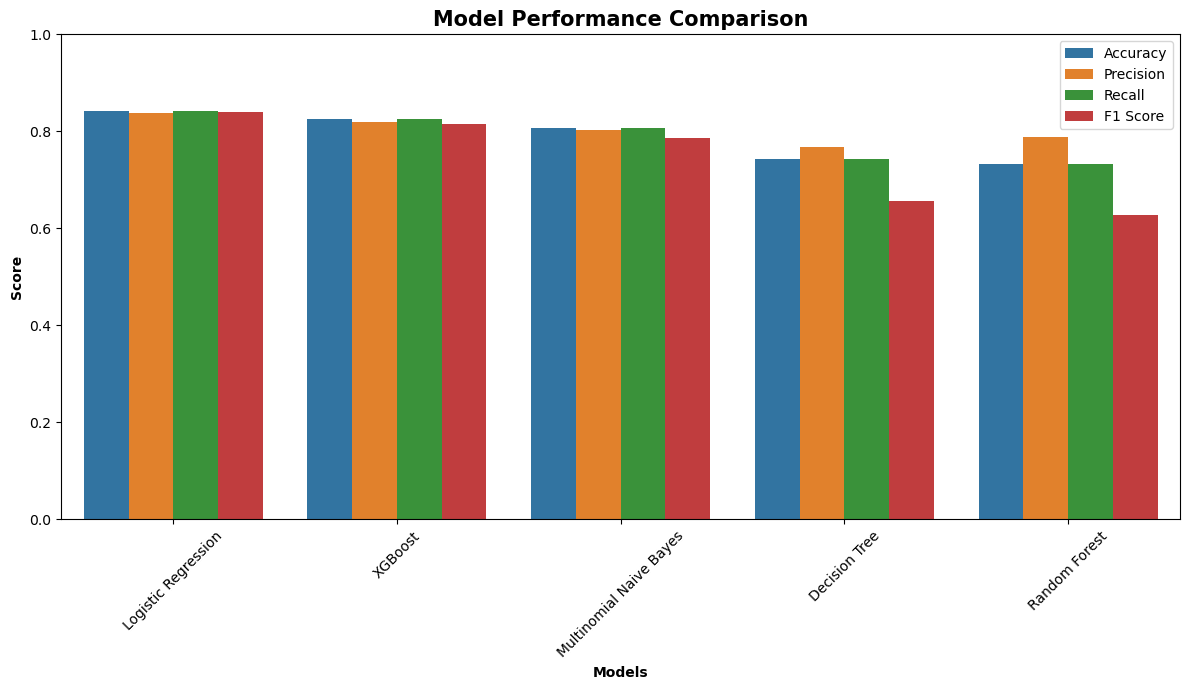

In [20]:
df_melted = results_df1.melt(id_vars='Model', 
                                value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                                var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')

plt.title('Model Performance Comparison', fontweight='bold', fontsize = 15)
plt.ylabel('Score', fontweight='bold')
plt.xlabel('Models', fontweight='bold')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
leg = plt.legend()
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
auc_scores = []
for name, model in models.items():
    model.fit(X_train, y_train)

    # Check for probability or decision score support
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        print(f"{name} does not support AUC scoring.")
        continue
    
    auc = roc_auc_score(y_test, y_scores)
    auc_scores.append({'Model': name, 'AUC': auc})
    print(f"AUC of {name}: {auc:.4f}")


AUC of Multinomial Naive Bayes: 0.8854
AUC of Logistic Regression: 0.9102
AUC of Random Forest: 0.8720
AUC of Decision Tree: 0.7835
AUC of XGBoost: 0.9111


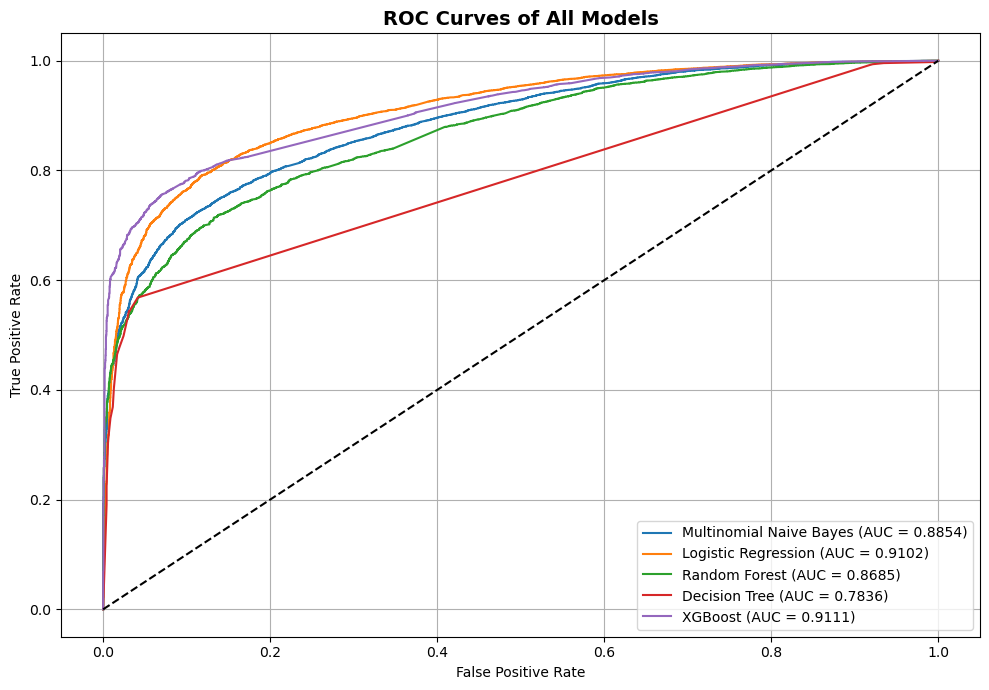

In [24]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 7))
for name, model in models.items():
    model.fit(X_train, y_train)

    # Get probability estimates for the positive class
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_probs = model.decision_function(X_test)
    else:
        print(f"{name} does not support probability or decision scores for ROC.")
        continue
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves of All Models', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
